In [ ]:
!pip install simpy

In [ ]:
import itertools
from collections import defaultdict

import random
import numpy as np
import pandas as pd
import math
import time
import torch
import simpy

import json

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

import tkinter as tk
from PIL import ImageTk

# Modelling the Prefill and Decode Latencies
## Prefill Latency
Assuming a batch size $B_p$, the number of tokens in a batch is:
$$
t_p = \Sigma_i^{B_p} l_i
$$
and sum of squares is:
$$
t'_p = \Sigma_i^{B_p} l_i^2
$$
where there are $l_i$ tokens in ith request.
Since we dont have KV Cache available yet, the time complexity for this step goes as $O(n^2)$ and saturates at low $t_p$ i.e.
$$
T_{Prefill} = \text{max}(C_{\text{min}}, C_0 + C_1  t_p + C_2 t'_p)
$$
where the constants $C_{\text{min}},$ $C_0$, $C_1$ and $C_2$ depend on various factors including the model architechture.

## Decode Latency
In this step since the KV Cache is available, the time complexity goes as $O(n)$.
Assuming a batch size of $B_d$, the number of tokens in a batch is:
$$
t_d = \Sigma_i^{B_d} l_i
$$
where there are $l_i$ tokens in ith batch.
$$
T_{Decode} = C_3 + C_4 t_d
$$


# Continous Batching Algorithm
Below we will simulate continous batching where the scheduling decision is made before each forward pass. Any given batch comprises either purely of prefill phase, or only decode phase. vLLM and TGI both provide multiple input arguments to control how to schedule one vs the other. In the simulation below we will use the following algorithm:
Two processes run in parallel.

* A process that accepts incoming requests and puts it in the **prefill queue**
* A process that either prefills or decodes.
  * If both **decode queue** and **prefill queue** are empty wait for the next request to arrive.
  * If the **prefill queue** is not empty and we have enough memory to store in kv cache the prefilled tokens and the number of sequences in **decode queue** is less than **MAX_NUM_SEQ** then prefill (with the **prefill batch size** determined by the number of requests in the **prefill queue** and how many can fit the kv cache) and put the sequences in **decode queue**
  * Else If we do not have enough memory in kv cache to **decode**, **evict** the newest sequence from **decode queue** and put it back to the **prefill queue** (with the new tokens generated).
  *  Else **decode** i.e take every request in  **decode queue** and decode one step. If a request finished decoding put it in **decoded queue**
  



In [ ]:
import simpy
import random
import numpy


NO_OF_ACTORS = 1






PREFILL_LATENCY_CONST_2 = 0
PREFILL_LATENCY_CONST_1 = 0.00006769375513
PREFILL_LATENCY_CONST_0 = 0.01969
PREFILL_LATENCY_CONST_MIN = 0.04

DECODE_LATENCY_CONST_1 = 0.000000766
DECODE_LATENCY_CONST_0 = 0.014
TOKENIZE_LATENCY_CONST =   0

MAX_NUM_BATCH_TOKENS = 512 # in prefill

TOTAL_NUM_GPU_BLOCKS = 2810
NUMBER_OF_TOKENS_PER_BLOCK = 16
MAX_NUM_TOKENS_ALLOWED = TOTAL_NUM_GPU_BLOCKS*NUMBER_OF_TOKENS_PER_BLOCK - MAX_NUM_BATCH_TOKENS # in kv cache
MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE = 0.9
MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE_NON_CRITICAL = 0.8
MAX_NUM_SEQ = 256


# size of each lora in units of KV Cache
LORA_DICT = {"tweet" : 1600, "sql" : 1600, "dummy-1" : 0, "dummy-2" : 0}




Above we are assuming the following behavior of decode and prefill latencies. They are based on A100, 40 GB, llama-3 architechture on vllm


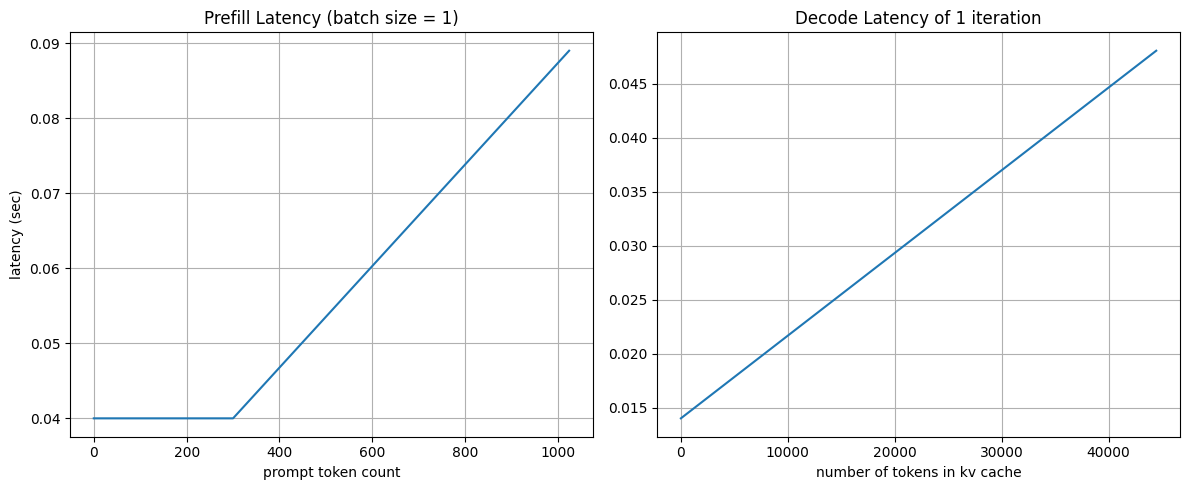

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns, size 12x5 inches


# Create a range of x values
x = [x for x in range(1025)]

x1 = [x for x in range(MAX_NUM_TOKENS_ALLOWED)]

# First plot
ax1.plot(x, [max(PREFILL_LATENCY_CONST_MIN, PREFILL_LATENCY_CONST_0 + PREFILL_LATENCY_CONST_1*t) for t in x],)
ax1.set_xlabel('prompt token count')
ax1.set_ylabel('latency (sec)')
ax1.set_title('Prefill Latency (batch size = 1)')

ax1.grid(True)

# Second plot
ax2.plot(x1, [ DECODE_LATENCY_CONST_0 + DECODE_LATENCY_CONST_1*t for t in x1],)
ax2.set_xlabel('number of tokens in kv cache')
#ax2.set_ylabel('latency (sec)')
ax2.set_title(f'Decode Latency of 1 iteration')

ax2.grid(True)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


LLMActor is the simulation of the model server. It has


*   Prefill Store: A queue where all to be prefilled requests are stored
*   Decode Store: A queue where all requests in KV Cache are stored
*   Decoded Store: A queue where the outputs are stored
*   Recompute Store: A queue where evicted requests are store (to be prefilled again)



In [ ]:
import simpy
import numpy as np
import queue

class LLMActor(object):
    """This class represents the propagation through an LLM Inference Actor managing multiple stores with Request objects."""

    def __init__(self, env, number_of_actors=1, actorId = 0):
        """Initialize the simulation environment and stores."""
        self.env = env
        self.prefill_store = simpy.Store(env)
        self.decode_store = simpy.FilterStore(env)
        self.decoded_store = simpy.Store(env)
        self.recompute_store = simpy.PriorityStore(env)
        self.actor = simpy.Resource(env, capacity=number_of_actors)  # Now dynamically set capacity
        self.user = simpy.Resource(env, capacity = 1)
        self.id = actorId
        self.lora_loaded = set()
        self.max_num_tokens_allowed = MAX_NUM_TOKENS_ALLOWED




    def get_num_tokens(self, store, include_remaining=True):
        """Calculate the total number of tokens in a given store, optionally including remaining output tokens."""
        if include_remaining:
            return np.sum([x.input_size + x.output_size - x.output_size_remaining for x in store.items])
        return np.sum([x.input_size for x in store.items])

    def get_num_tokens_in_decode(self):
        """Return the number of total tokens currently in the decode store."""
        return self.get_num_tokens(self.decode_store)

    def get_num_prompt_tokens_in_decode(self):
        """Return the number of input tokens currently in the decode store."""
        return np.sum([x.input_size for x in self.decode_store.items])

    def get_num_gen_tokens_in_decode(self):
        """Return the number of output tokens remaining to be generated in the decode store."""
        return np.sum([x.output_size - x.output_size_remaining for x in self.decode_store.items])

    def get_num_gen_tokens_in_decoded(self):
        """Return the number of output tokens remaining to be generated in the decode store."""
        return np.sum([x.output_size - x.output_size_remaining for x in self.decoded_store.items])

    def get_num_prompt_tokens_in_decoded(self):
        """Return the number of output tokens remaining to be generated in the decode store."""
        return np.sum([x.input_size for x in self.decoded_store.items])

    def get_queue_size(self, store):
        """Return the current queue size of a given store."""
        return len(store.items)

    def get_decode_queue_size(self):
      return self.get_queue_size(self.decode_store)

    def get_prefill_queue_size(self):
      return self.get_queue_size(self.prefill_store)

    def get_recompute_queue_size(self):
      return self.get_queue_size(self.recompute_store)

    def get_decoded_queue_size(self):
      return self.get_queue_size(self.decoded_store)

    def get_min_expected_num_tokens_in_kvcache_after_prefill(self):
        """Calculate the minimum expected number of tokens in the key-value cache after prefill."""
        num_tokens_decode = self.get_num_tokens_in_decode()
        if self.get_queue_size(self.recompute_store) > 0:
            item = self.recompute_store.items[0].item
            return num_tokens_decode + item.input_size + item.output_size - item.output_size_remaining
        elif self.get_queue_size(self.prefill_store) > 0:
            item = self.prefill_store.items[0]
            return num_tokens_decode + item.input_size + item.output_size - item.output_size_remaining

        return num_tokens_decode


    def get_expected_num_tokens_in_kvcache_after_decode(self):
          return self.get_decode_queue_size() + self.get_num_tokens_in_decode()


















The request class stores requests with its attributes like input size, output size etc.

In [ ]:


import simpy
import numpy as np

class Request:
    def __init__(self, id, arrival_time, input_size, output_size, lora):
        self.id = id
        self.arrival_time = arrival_time
        self.input_size = input_size

        self.start_prefill_time = None
        self.prefill_time = None
        self.tokens_in_kv_cache_at_start_of_decode = None
        self.start_decode_time = None
        self.end_first_token_decode_time = None
        self.end_decode_time = None
        self.output_size = output_size
        self.output_size_remaining = output_size
        self.recompute_count = 0
        self.target_pod = None
        self.target_latency = np.inf
        self.tokens_in_kv_cache_at_start_of_decode = None

        self.queue_size_before_prefill = None


        self.estimated_latency = 0

        self.lora = lora



def create_request(id, time, input_size, output_size, lora = None):
    """Creates a new request with given parameters."""
    return Request(id, time, input_size, output_size, lora)

def determine_size(distribution_mean, distribution_std, sizes_dict=None, id=None):
    """Determines the size of a request component based on a dictionary, normal distribution, or fixed size."""
    if sizes_dict and id in sizes_dict:
        return max(1, sizes_dict[id])
    return max(1.0, np.round(np.abs(np.random.normal(distribution_mean, distribution_std, 1))).astype(int)[0])





Metrics can run as another process to emit metrics periodically

In [ ]:
def metrics(env, llmactor):
  while True:
      yield env.timeout(10)
      cur_time = env.now
      num_of_prompt_tokens = llmactor.get_num_prompt_tokens_in_decode() + llmactor.get_num_prompt_tokens_in_decoded()
      num_of_gen_tokens = llmactor.get_num_gen_tokens_in_decode() + llmactor.get_num_gen_tokens_in_decoded()
      running_req = llmactor.get_decode_queue_size()
      pending_req = llmactor.get_prefill_queue_size()
      gpu_kv_cache_usage = llmactor.get_num_tokens_in_decode()/llmactor.max_num_tokens_allowed * 100
      print(f'llmactor {llmactor.id} Avg prompt throughput: {num_of_prompt_tokens/cur_time} tokens/s, Avg generation throughput: {num_of_gen_tokens/cur_time}, Running: {running_req} reqs, Pending: {pending_req} reqs, GPU KV cache usage: {gpu_kv_cache_usage}%')

The continous batching algorithm

In [ ]:
import simpy
import numpy as np

def should_process_prefill_or_recompute(llmactor, env):
    """Check if the system should process prefill or recompute based on queue sizes and memory constraints."""
    return (llmactor.get_prefill_queue_size() > 0 or llmactor.get_recompute_queue_size() > 0) and \
           (llmactor.get_decode_queue_size() < MAX_NUM_SEQ) and \
           (llmactor.get_min_expected_num_tokens_in_kvcache_after_prefill() / (llmactor.max_num_tokens_allowed + 0.0) < MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE)

def fetch_prefill_items(llmactor, env,  ):
    """Fetch items to prefill if there is memory either from recompute (p0) or from prefill (p1)"""
    items_to_prefill = []
    prefill_batch_size = 0
    num_new_seq = 0

    while llmactor.get_recompute_queue_size() > 0:
        oldest_item = llmactor.recompute_store.items[0].item
        oldest_item_len = oldest_item.input_size + oldest_item.output_size - oldest_item.output_size_remaining

        if any([
            llmactor.get_decode_queue_size() + num_new_seq + 1 > MAX_NUM_SEQ,
            prefill_batch_size + oldest_item_len > MAX_NUM_BATCH_TOKENS,
            (prefill_batch_size + num_new_seq + llmactor.get_num_tokens_in_decode()) / (llmactor.max_num_tokens_allowed + 0.0) >= MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE
        ]):
            break

        prefill_batch_size += oldest_item_len
        num_new_seq += 1
        msg = yield llmactor.recompute_store.get()
        items_to_prefill.append(msg.item)

    while llmactor.get_prefill_queue_size() > 0:
        oldest_item = llmactor.prefill_store.items[0]
        oldest_item_len = oldest_item.input_size + oldest_item.output_size - oldest_item.output_size_remaining

        if any([
            llmactor.get_decode_queue_size() + num_new_seq + 1 > MAX_NUM_SEQ,
            prefill_batch_size + oldest_item_len > MAX_NUM_BATCH_TOKENS,
            (prefill_batch_size + num_new_seq + llmactor.get_num_tokens_in_decode()) / (llmactor.max_num_tokens_allowed + 0.0) >= MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE
        ]):
            break

        prefill_batch_size += oldest_item_len
        num_new_seq += 1
        msg = yield llmactor.prefill_store.get()
        items_to_prefill.append(msg)

    #if (len(items_to_prefill) == 0) and llmactor.get_prefill_queue_size() > 0:
    #    msg = yield llmactor.prefill_store.get()
    #    items_to_prefill.append(msg)

    return items_to_prefill

def process_prefill_items( llmactor, env, items_to_prefill, req_dict_prefill, req_dict, logging = False):
    """Process prefill items, updating times and managing item states."""
    prefill_len = np.sum([x.input_size + x.output_size - x.output_size_remaining for x in items_to_prefill])
    prefill_delay = calculate_prefill_delay(prefill_len, len(items_to_prefill), TOKENIZE_LATENCY_CONST, PREFILL_LATENCY_CONST_2, PREFILL_LATENCY_CONST_1 , PREFILL_LATENCY_CONST_0, PREFILL_LATENCY_CONST_MIN)


    for item in items_to_prefill:
        #lora stuff
        if item.lora is not None:
              if item.lora not in llmactor.lora_loaded:
                llmactor.lora_loaded.add(item.lora)
                llmactor.max_num_tokens_allowed -=  LORA_DICT[item.lora]

        if item.start_prefill_time is None:
            item.start_prefill_time = env.now
            item.end_prefill_time = item.start_prefill_time + prefill_delay
        item.end_decode_time = llmactor.env.now + prefill_delay
        item.output_size_remaining -= 1

        if item.output_size_remaining == 0:
            llmactor.decoded_store.put(item)
        else:
            llmactor.decode_store.put(item)
            if item.output_size_remaining <= 0:
              if logging:
                print(f'llmactor {llmactor.id} {item.id} item.output_size_remaining {item.output_size_remaining}')
              assert item.output_size_remaining > 0
        req_dict_prefill[item.id] = item
        req_dict[item.id] = item
    return prefill_delay

def should_recompute(llmactor, env):
    """Determine if items should be moved to recompute based on memory usage."""
    return llmactor.get_expected_num_tokens_in_kvcache_after_decode() / (llmactor.max_num_tokens_allowed + 0.0) > MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE

def remove_from_decode_store(llmactor, env, req_dict_prefill, req_dict, logging = False):
    """Manage the recomputation of items based on priority and conditions."""
    while should_recompute(llmactor, env):
        if llmactor.get_decode_queue_size() > 0:
            newest_decode_item_id = llmactor.decode_store.items[-1].id  # newest item goes to recompute
            if logging:
              print(f'llmactor {llmactor.id} removing from decode store sequence {newest_decode_item_id}')
            req_dict[newest_decode_item_id].recompute_count += 1

            newest_decode_item = yield llmactor.decode_store.get(lambda req: req.id == newest_decode_item_id)
            llmactor.recompute_store.put(simpy.PriorityItem(item=newest_decode_item, priority=newest_decode_item_id))

def decode_items(llmactor, env, req_dict_prefill, req_dict, logging=False):
    """Process decoding of items, handling them appropriately based on their remaining output size."""
    num_items_to_decode = llmactor.get_decode_queue_size()
    before_decoding_token_count = llmactor.get_num_tokens_in_decode()
    temp_items = []
    decode_delay = calculate_decode_delay(before_decoding_token_count, num_items_to_decode, TOKENIZE_LATENCY_CONST, DECODE_LATENCY_CONST_1, DECODE_LATENCY_CONST_0)
    if logging:
      print(f'llmactor {llmactor.id} Decoding sequences {[x.id for x in llmactor.decode_store.items]} items with delay {decode_delay}')

    for _ in range(num_items_to_decode):
        msg = yield llmactor.decode_store.get()
        if msg.output_size_remaining == msg.output_size-1:
          msg.start_decode_time = env.now
          msg.tokens_in_kv_cache_at_start_of_decode = before_decoding_token_count
        msg.output_size_remaining -= 1
        if msg.output_size_remaining < 0:
            raise ValueError(f'Output size remaining negative for {msg.id}')

        temp_items.append(msg)
        req_dict_prefill[msg.id] = msg
        req_dict[msg.id] = msg



    for item in temp_items:
        if item.output_size_remaining == 0:
            item.end_decode_time = env.now + decode_delay

            llmactor.decoded_store.put(item)
        else:
            item.end_decode_time = env.now + decode_delay
            llmactor.decode_store.put(item)

    return decode_delay

def calculate_decode_delay(token_count, num_items_to_decode, TOKENIZE_LATENCY_CONST, DECODE_LATENCY_CONST_1=0.01, DECODE_LATENCY_CONST_0=1):
    """Calculate delay based on the token count and latency constants."""
    return token_count * DECODE_LATENCY_CONST_1 + DECODE_LATENCY_CONST_0 + TOKENIZE_LATENCY_CONST * num_items_to_decode

def calculate_prefill_delay(token_count, num_items_to_prefill, TOKENIZE_LATENCY_CONST, PREFILL_LATENCY_CONST_2=0.01, PREFILL_LATENCY_CONST_1 = 0.01, PREFILL_LATENCY_CONST_0=1, PREFILL_LATENCY_CONST_MIN=0):
    """Calculate delay based on the token count and latency constants."""
    return max(PREFILL_LATENCY_CONST_MIN, (token_count * token_count * PREFILL_LATENCY_CONST_2 + token_count*PREFILL_LATENCY_CONST_1 + PREFILL_LATENCY_CONST_0 + num_items_to_prefill * TOKENIZE_LATENCY_CONST))

def prefill_or_decode(env, llmactor, req_dict_prefill, req_dict, logging = False):
    """Main process for managing prefill, decode, or recompute operations."""
    while True:

        with llmactor.actor.request() as req:

            yield req
            if (llmactor.get_decode_queue_size() == 0) and (llmactor.get_prefill_queue_size() == 0) and (llmactor.get_recompute_queue_size() == 0):
                yield env.timeout(1/1000.0)
            elif should_process_prefill_or_recompute(llmactor, env):
                items_to_prefill = yield from fetch_prefill_items(llmactor, env)
                prefill_delay =  process_prefill_items( llmactor, env,items_to_prefill, req_dict_prefill, req_dict)
                if logging:
                  print(f'llmactor {llmactor.id} Processed prefill for sequences {[x.id for x in items_to_prefill]} with delay {prefill_delay}')
                yield env.timeout(prefill_delay)  # Assume prefill_delay is calculated somewhere
            else:
              if should_recompute(llmactor, env):
                yield from remove_from_decode_store(llmactor, env, req_dict_prefill, req_dict)
              if llmactor.get_decode_queue_size() > 0:
                decode_delay =   yield from decode_items(llmactor, env, req_dict_prefill, req_dict)
                yield env.timeout(decode_delay)


# LoadBalancer Class for LLM Inference

This code defines a `LoadBalancer` class designed to manage and distribute inference requests across multiple Language Model (LLM) actors (aka **model servers**).

## Key Features

1. **Dynamic Load Balancing**: The class can distribute requests across multiple LLM actors using various routing strategies.

2. **Latency Estimation**: It can estimate prefill, decode, and total latency for requests based on historical data.

3. **Resource Management**: The class tracks and manages resources like GPU memory usage and pending tokens across all LLM actors.

4. **LoRA (Low-Rank Adaptation) Support**: It can handle requests that require specific LoRA configurations.

5. **Queueing Mechanism**: Implements a queueing system for handling requests when the system is under high load.

6. **Metrics Collection**: Provides functionality for collecting and processing metrics from all LLM actors.

## Main Components

- **Initialization**: Sets up the simulation environment, LLM actors, and various data structures for request management.

- **Latency Estimation**: Methods like `estimate_latency` calculate expected processing times for requests.

- **Pod Selection**: Functions like `find_target_pod` determine the best LLM actor to handle a given request based on various criteria.

- **Request Generation and Processing**: The `process` method manages the generation of inference requests and their distribution to LLM actors.

- **Queue Management**: Methods for enqueueing and dequeueing requests based on system load and request priorities.

- **Resource Monitoring**: Functions to check system saturation, pending token percentages, and overall system load.


In [ ]:
from re import I
from threading import active_count
import simpy
import numpy as np

class LoadBalancer(object):
    """
    LoadBalancer class to manage the distribution of requests across multiple servers.
    It handles request queuing, target pod selection, and latency estimation.
    """
    def __init__(self, env, number_of_servers = 1, list_of_llmactors = [], req_dict_prefill = {}, req_dict = {}, messages_remaining_cnt = None,  queueing_perc = 0.2):
        """
        Initializes the LoadBalancer class with environment, server configurations, and other parameters.

        :param env: The simulation environment.
        :param number_of_servers: The number of servers in the load balancer.
        :param list_of_llmactors: List of actors (servers) handling requests.
        :param req_dict_prefill: Dictionary to store prefill request data.
        :param req_dict: Dictionary to store request data.
        :param messages_remaining_cnt: Counter for the number of remaining messages.
        :param queueing_perc: Threshold percentage for queueing requests.
        """
        self.number_of_servers = number_of_servers
        assert len(list_of_llmactors) == number_of_servers
        self.list_of_llmactors = list_of_llmactors
        self.env = env
        self.req_dict_prefill = req_dict_prefill
        self.req_dict = req_dict
        self.queues = {}
        self.all_target_latencies = set()

        self.messages_remaining_cnt = messages_remaining_cnt

        self.queueing_perc = queueing_perc


    def estimate_total_latency(self, llmactor, input_size, output_size, percentile = 95):
        """
        Estimates total latency for the request processing by calculating prefill, decode, and queue times.

        """
        estimate_total_latency_list = []
        estimated_prefill_latency_list = []
        estimated_decode_latency_list = []
        estimated_queue_time_list = []
        current_tokens_in_kv_cache = llmactor.get_num_tokens_in_decode()
        for item in llmactor.decode_store.items:
          tokens_in_kv_cache_at_start_of_decode = item.tokens_in_kv_cache_at_start_of_decode if  item.tokens_in_kv_cache_at_start_of_decode is not None else 0
          decode_delays_per_output_token_normalized_by_batch_size = 0 if tokens_in_kv_cache_at_start_of_decode == 0 else ((item.end_decode_time - item.end_prefill_time)/tokens_in_kv_cache_at_start_of_decode)/(item.output_size - item.output_size_remaining )
          estimated_decode_time = decode_delays_per_output_token_normalized_by_batch_size * current_tokens_in_kv_cache * output_size


          estimated_queue_time = item.start_prefill_time - item.arrival_time


          estimated_prefill_time = (item.end_prefill_time - item.arrival_time + 0.0)/item.input_size *input_size


          estimate_total_latency_list.append(estimated_prefill_time + estimated_decode_time + estimated_queue_time)

          estimated_prefill_latency_list.append(estimated_prefill_time)
          estimated_decode_latency_list.append(estimated_decode_time)
          estimated_queue_time_list.append(estimated_queue_time)

        estimated_prefill_latency = 0 if len(estimated_prefill_latency_list) == 0 else np.percentile(estimated_prefill_latency_list, percentile)
        estimated_decode_latency = 0 if len(estimated_decode_latency_list) == 0 else np.percentile(estimated_decode_latency_list, percentile)
        estimated_queue_time =  0 if len(estimated_queue_time_list) == 0 else np.percentile(estimated_queue_time_list, percentile)
        estimated_total_latency = 0 if len(estimate_total_latency_list) == 0 else np.percentile(estimate_total_latency_list, percentile)

        return estimated_total_latency, estimated_prefill_latency, estimated_decode_latency

    def estimate_avg_latency(self, llmactor, input_size, output_size):
        """
        Estimates average latency by calculating the mean prefill, decode, and queue times.

        """
        estimate_total_latency_list = []
        estimated_prefill_latency_list = []
        estimated_decode_latency_list = []
        estimated_queue_time_list = []
        current_tokens_in_kv_cache = llmactor.get_num_tokens_in_decode()
        for item in llmactor.decoded_store.items:
          tokens_in_kv_cache_at_start_of_decode = item.tokens_in_kv_cache_at_start_of_decode if  item.tokens_in_kv_cache_at_start_of_decode is not None else 0
          decode_delays_per_output_token_normalized_by_batch_size = 0 if tokens_in_kv_cache_at_start_of_decode == 0 else ((item.end_decode_time - item.end_prefill_time)/tokens_in_kv_cache_at_start_of_decode)/(item.output_size - item.output_size_remaining )
          estimated_decode_time = decode_delays_per_output_token_normalized_by_batch_size * current_tokens_in_kv_cache * output_size


          estimated_queue_time = item.start_prefill_time - item.arrival_time


          estimated_prefill_time = (item.end_prefill_time - item.arrival_time + 0.0)/item.input_size *input_size


          estimate_total_latency_list.append(estimated_prefill_time + estimated_decode_time + estimated_queue_time)

          estimated_prefill_latency_list.append(estimated_prefill_time)
          estimated_decode_latency_list.append(estimated_decode_time)
          estimated_queue_time_list.append(estimated_queue_time)

        estimated_prefill_latency = 0 if len(estimated_prefill_latency_list) == 0 else np.mean(estimated_prefill_latency_list)
        estimated_decode_latency = 0 if len(estimated_decode_latency_list) == 0 else np.mean(estimated_decode_latency_list)
        estimated_queue_time =  0 if len(estimated_queue_time_list) == 0 else np.mean(estimated_queue_time_list)
        estimated_total_latency = 0 if len(estimate_total_latency_list) == 0 else np.mean(estimate_total_latency_list)

        return estimated_total_latency, estimated_prefill_latency, estimated_decode_latency


    def check_saturations(self, max = MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE_NON_CRITICAL):
      """
        Checks if all pods are saturated based on the number of tokens in cache.

      """

      all_pod_saturated = True
      for llmactor in self.list_of_llmactors:
        if llmactor.get_min_expected_num_tokens_in_kvcache_after_prefill()/ (llmactor.max_num_tokens_allowed + 0.0) < max:
          all_pod_saturated = False
      return all_pod_saturated

    def get_pending_tokens_perc(self, llmactor):
        """
        Calculates the percentage of pending tokens for a specific LLM actor.

        """
        pending_tokens = 0
        max_num_tokens_allowed = llmactor.max_num_tokens_allowed
        for item in llmactor.decode_store.items:
            pending_tokens += item.output_size + item.input_size

        for item in llmactor.prefill_store.items:
            pending_tokens += item.output_size + item.input_size
        return pending_tokens/(max_num_tokens_allowed + 0.0)

    def get_overall_pending_tokens_perc(self):
        """
        Calculates the overall percentage of pending tokens across all LLM actors.

        """
        total_pending_tokens = 0
        total_max_tokens = 0
        for llmactor in self.list_of_llmactors:

          total_pending_tokens += self.get_pending_tokens_perc(llmactor) * llmactor.max_num_tokens_allowed
          total_max_tokens += llmactor.max_num_tokens_allowed
        return total_pending_tokens/total_max_tokens

    def get_lora_affinity(self, lora_requested):
         """
         Determines which pods have the requested LoRA models loaded.
         """
         min_lora_count = np.inf
         pods_with_lora_requested = []
         if lora_requested != "":
            for llmactor in self.list_of_llmactors:
              if lora_requested in llmactor.lora_loaded:
                pods_with_lora_requested.append(llmactor)
         if len(pods_with_lora_requested) == 0:
            for llmactor in self.list_of_llmactors:
              if len(llmactor.lora_loaded) < min_lora_count:
                min_lora_count = len(llmactor.lora_loaded)
                pods_with_lora_requested = [llmactor]
              elif len(llmactor.lora_loaded) == min_lora_count:
                pods_with_lora_requested.append(llmactor)
         return pods_with_lora_requested


    def find_target_pod_based_on_min_latency(self, pods, input_size, output_size,  target_latency = np.inf, output_error = 0, max_tokens = 1024, buffer = 1):

        """
        Finds the target pod with the minimum latency for processing a request.
        """
        all_candiated_pods_based_on_min_expected_latency = []
        min_expected_latency = np.inf




        for i, llmactor in enumerate(pods):

            #estimate latencies
            output_size_for_estimation = min(max(1.0, np.round(np.abs(np.random.normal(output_size, output_size * output_error, 1))).astype(int)[0]), max_tokens)
            estimated_latency, estimated_prefill_latency, estimated_decode_latency = self.estimate_avg_latency(llmactor, input_size, output_size_for_estimation)
            estimated_latency_per_output_token = (estimated_latency) / output_size_for_estimation


            if estimated_latency_per_output_token < min_expected_latency:
              min_expected_latency = estimated_latency_per_output_token
              all_candiated_pods_based_on_min_expected_latency = [i]
            elif estimated_latency_per_output_token == min_expected_latency:
              all_candiated_pods_based_on_min_expected_latency.append(i)


        # return a random one
        if len(all_candiated_pods_based_on_min_expected_latency) > 0:
          random_pod_index = random.choice(all_candiated_pods_based_on_min_expected_latency)
          return self.list_of_llmactors[random_pod_index], estimated_latency_per_output_token
        else:
          return None, estimated_latency_per_output_token


    def find_target_pod_based_on_max_pending(self, pods, input_size, output_size,  target_latency = np.inf, output_error = 0, max_tokens = 1024, buffer = 0.75):

        """
        Finds the target pod based on maximum pending requests under a certain latency.
        """
        all_candiated_pods_based_on_maximum_pending_req = []

        min_pending_token_perc = np.inf
        max_pending_token_below_target_perc = 0
        min_kv_cache_usage = np.inf
        drop_request = False
        if target_latency == np.inf:
          drop_request = True
        max_tokens_in_kv_before_eviction = MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE
        latency_estimations = {}

        min_lora_count = np.inf


        for i, llmactor in enumerate(pods):

            #estimate latencies
            output_size_for_estimation = min(max(1.0, np.round(np.abs(np.random.normal(output_size, output_size * output_error, 1))).astype(int)[0]), max_tokens)
            estimated_latency, estimated_prefill_latency, estimated_decode_latency = self.estimate_total_latency(llmactor, input_size, output_size_for_estimation)
            estimated_latency_per_output_token = (estimated_latency) / output_size_for_estimation
            latency_estimations[i] = estimated_latency_per_output_token

            #get pending tokens
            pending_token_perc = self.get_pending_tokens_perc(llmactor)


            # get matching pods
            if estimated_latency_per_output_token < buffer*target_latency and pending_token_perc > max_pending_token_below_target_perc:
              max_pending_token_below_target_perc = pending_token_perc
              all_candiated_pods_based_on_maximum_pending_req = [i]
            elif estimated_latency_per_output_token <  buffer*target_latency and pending_token_perc == max_pending_token_below_target_perc:
              all_candiated_pods_based_on_maximum_pending_req.append(i)


        # return a random one
        if len(all_candiated_pods_based_on_maximum_pending_req) > 0:
          random_pod_index = random.choice(all_candiated_pods_based_on_maximum_pending_req)
          return self.list_of_llmactors[random_pod_index],   latency_estimations[random_pod_index]
        else:
          return None, 0


    def find_target_pod_based_on_min_pending(self, pods, eviction_safe = False, max_kv_perc = MAX_GPU_MEMORY_PERC_BEFORE_RECOMPUTE ):


        """
        Finds the target pod based on the minimum pending tokens and safe eviction condition.
        """
        all_candiated_pods_based_on_minimum_pending_req = []
        min_pending_token_perc = np.inf

        for i, llmactor in enumerate(pods):
            pending_token_perc = self.get_pending_tokens_perc(llmactor)
            expected_kvcache_usage_after_prefill = llmactor.get_min_expected_num_tokens_in_kvcache_after_prefill() / (llmactor.max_num_tokens_allowed + 0.0)

            if eviction_safe:
              if pending_token_perc < min_pending_token_perc and expected_kvcache_usage_after_prefill < max_kv_perc:
                all_candiated_pods_based_on_minimum_pending_req = [i]
                min_pending_token_perc = pending_token_perc
              elif pending_token_perc == min_pending_token_perc:
                all_candiated_pods_based_on_minimum_pending_req.append(i)
            else:
               if pending_token_perc < min_pending_token_perc:
                all_candiated_pods_based_on_minimum_pending_req = [i]
                min_pending_token_perc = pending_token_perc
               elif pending_token_perc == min_pending_token_perc:
                all_candiated_pods_based_on_minimum_pending_req.append(i)


        # return a random one
        if len(all_candiated_pods_based_on_minimum_pending_req) > 0:
          random_pod_index = random.choice(all_candiated_pods_based_on_minimum_pending_req)
          return self.list_of_llmactors[random_pod_index]
        else:
          return None


    def find_target_pod_based_on_min_kv_cache(self, pods, ):

        """
        Finds the target pod with the minimum usage of KV cache.
        """

        all_candiated_pods_based_on_min_kv_cache_usage = []
        min_kv_cache_usage = np.inf

        for i, llmactor in enumerate(pods):
            expected_kvcache_usage_after_prefill = llmactor.get_min_expected_num_tokens_in_kvcache_after_prefill() / (llmactor.max_num_tokens_allowed + 0.0)

            if expected_kvcache_usage_after_prefill < min_kv_cache_usage:
              min_kv_cache_usage = expected_kvcache_usage_after_prefill
              all_candiated_pods_based_on_min_kv_cache_usage = [i]
            elif expected_kvcache_usage_after_prefill == min_kv_cache_usage:
              all_candiated_pods_based_on_min_kv_cache_usage.append(i)


        # return a random one
        if len(all_candiated_pods_based_on_min_kv_cache_usage) > 0:
          random_pod_index = random.choice(all_candiated_pods_based_on_min_kv_cache_usage)
          return self.list_of_llmactors[random_pod_index]
        else:
          return None




    def find_target_pod(self, routing_type, input_size, output_size,  target_latency = np.inf, lora_requested = "", output_error = 0, max_tokens = 1024):
        """
        Finds the target pod based on routing strategy and various factors like latency, pending tokens, or LoRA.
        """

        target_pod = None
        latency_esimated = 0

        active_req_target_latency_in_window = self.getActiveReqTargetLatencyInWindow()
        violations_present = self.getViolationsTargetLatencyInWindow()


        if target_latency == np.inf:
          all_pods_saturated = self.check_saturations()
          if all_pods_saturated and len(active_req_target_latency_in_window) > 0:
            return target_pod, latency_esimated
          if violations_present and len(active_req_target_latency_in_window) > 0:
            return target_pod, latency_esimated

        if routing_type == "least":
          target_pod = self.find_target_pod_based_on_min_kv_cache(self.list_of_llmactors, )
          return target_pod, latency_esimated
        if routing_type == "leastPseudo":
          target_pod = self.find_target_pod_based_on_min_pending(self.list_of_llmactors, eviction_safe=False)
          return target_pod, latency_esimated
        elif routing_type == "leastlatency":
          target_pod, latency_esimated = self.find_target_pod_based_on_min_latency(self.list_of_llmactors, input_size, output_size, target_latency)
          return target_pod, latency_esimated
        elif lora_requested != "":
          lora_pods = self.get_lora_affinity(lora_requested)
          target_pod, latency_esimated = self.find_target_pod_based_on_max_pending(lora_pods, input_size, output_size, target_latency)
          if target_pod is  None:
            target_pod, latency_esimated = self.find_target_pod_based_on_max_pending(self.list_of_llmactors, input_size, output_size, target_latency)
          if target_pod is None:
            target_pod = self.find_target_pod_based_on_min_pending(lora_pods, eviction_safe=True)
          if target_pod is None:
            target_pod = self.find_target_pod_based_on_min_pending(self.list_of_llmactors,  eviction_safe=False)
          return target_pod, latency_esimated

        else:
          pods = self.list_of_llmactors
          target_pod, latency_esimated = self.find_target_pod_based_on_max_pending(pods, input_size, output_size, target_latency)
          if target_pod is None:
            target_pod = self.find_target_pod_based_on_min_pending(self.list_of_llmactors,  eviction_safe=False)
          return target_pod, latency_esimated


    def queueing_signal(self):
      """
        Checks if all pods are saturated based on the queueing percentage.
      """
      all_pod_saturated = self.get_overall_pending_tokens_perc() > self.queueing_perc


      return all_pod_saturated


    def dequeueing_signal(self):
      """
        Checks if the system should start dequeueing requests from the queue.
      """
      all_pod_saturated = self.get_overall_pending_tokens_perc() > self.queueing_perc


      return all_pod_saturated




    def check_if_queues_empty(self):
        """
        Checks if all queues are empty.
        """
        for k, v in self.queues.items():
          if not v.empty():
            return False
        return True

    def dequeue(self):
        """
        Dequeues the highest-priority request from the queue. Current logic is simple, deque in order of active target latenices
        """
        active_targets = sorted(self.getActiveReqTargetLatencyInWindow(np.inf))
        for k in active_targets:
          if k in self.queues and not self.queues[k].empty():
            req = self.queues[k].get()
            return req
        return None


    def dequeue_process(self, routing_type, drop_late_requests = False):
        """
        Continuously dequeues requests and routes them to target pods for processing.

        :param routing_type: The routing strategy to use for dequeuing requests.
        :param drop_late_requests: Flag to drop requests that exceed target latency.
        """
        while True:
            if not self.check_if_queues_empty() and not self.dequeueing_signal():
                # Get the request with the highest SLO violation
                req = self.dequeue()
                if   req:
                  #if self.env.now - req.arrival_time > req.target_latency:
                      #print(f"dropped req {req.id} {req.target_latency}")
                  if (drop_late_requests == False) or (self.env.now - req.arrival_time < 100*req.target_latency): #ad-hoc
                    target_pod, estimated_latency = self.find_target_pod(routing_type, req.input_size, req.output_size, req.target_latency, req.lora)
                    req.target_pod = target_pod.id
                    req.estimated_latency = estimated_latency
                    req.queue_size_before_prefill = target_pod.get_prefill_queue_size()

                    #print(f"dequeued req {req.id} {req.target_latency}")
                    # Send it to the appropriate pod for processing
                    target_pod = self.list_of_llmactors[req.target_pod]
                    target_pod.prefill_store.put(req)
                    self.req_dict_prefill[req.id] = req
                    #print(f"Dequeued request {req.id} and sent to pod {req.target_pod}")
                else:
                    yield self.env.timeout(0.001)  # Adjust the delay as per your requirements
            # Check again after a small delay
            else:
              yield self.env.timeout(0.001)  # Adjust the delay as per your requirements




    def getActiveReqTargetLatencyInWindow(self, time_windows = 300):
      """
        Retrieves active target latencies within a specified time window.

        :param time_windows: Time window in which to check for active requests.
        :return: Set of active target latencies.
      """
      active_targets = set()
      for llmactor in self.list_of_llmactors:
        if llmactor.get_prefill_queue_size() > 0:
          for req in llmactor.prefill_store.items:
            if req.target_latency != np.inf:
              active_targets.add(req.target_latency)
        if llmactor.get_decode_queue_size() > 0:
          for req in llmactor.decode_store.items:
            if req.target_latency != np.inf:
              active_targets.add(req.target_latency)
        if llmactor.get_recompute_queue_size() > 0:
          for req in llmactor.recompute_store.items:
            if req.item.target_latency != np.inf:
              active_targets.add(req.item.target_latency)
        if llmactor.get_decoded_queue_size() > 0:
          for req in llmactor.decoded_store.items:
            if (req.target_latency != np.inf) and (self.env.now - req.arrival_time < time_windows) :
              active_targets.add(req.target_latency)
      return active_targets

    def getViolationsTargetLatencyInWindow(self, time_windows = 300, percentile = 0.04):
      """
        Checks for latency violations within a specified time window.

        :param time_windows: Time window in which to check for latency violations.
        :param percentile: The violation threshold percentile.
        :return: Boolean indicating if violations occurred.
      """
      didViolate = False
      violation_dict = {}
      req_dict = {}
      for llmactor in self.list_of_llmactors:
        if llmactor.get_decoded_queue_size() > 0:
          for req in llmactor.decoded_store.items :
              if  (req.target_latency == np.inf)  or  (self.env.now - req.arrival_time > time_windows):
                continue
              if req.target_latency not in violation_dict:
                violation_dict[req.target_latency] = 0
              if req.target_latency not in req_dict:
                req_dict[req.target_latency] = 0

              req_dict[req.target_latency] += 1
              if ((req.end_decode_time - req.arrival_time)/req.output_size > req.target_latency ):
                  violation_dict[req.target_latency] += 1


      for target_latency in violation_dict:
        if violation_dict[target_latency]/req_dict[target_latency] > percentile:
          didViolate = True
      return didViolate



    def generate_request_inference_gateway( self, rate, lora_requested,  target_latency_list, prefix_latency_list,  routing_type = "random",  prompt_output_tuple = None, mean_request_size = None, std_request_size = None, mean_output_size = None, std_output_size = None, estimated_output_size = None):
        """
        Generates and routes requests through the inference gateway based on the provided parameters.

        """

        cnt = 0
        timeout_interval = 1 / rate


        while True :
          #print(self.messages_remaining_cnt)
          if self.messages_remaining_cnt is not None and  self.messages_remaining_cnt <= 0:
            break

          target_latency_index = random.choice([x for x in range(len(target_latency_list))]) #random.choice([0.02, 0.1])
          target_latency = target_latency_list[target_latency_index]
          prefix = prefix_latency_list[target_latency_index]
          if prompt_output_tuple is None:
            mean_request_size = mean_request_size
            std_request_size = std_request_size
            mean_output_size = mean_output_size
            std_output_size = std_output_size
            input_size = determine_size(mean_request_size, std_request_size, None, None)
            output_size = determine_size(mean_output_size, std_output_size, None, None)
          else:
            input_output_size = prompt_output_tuple[random.randint(0, len(prompt_output_tuple)-1)]
            input_size = input_output_size[0]
            output_size = input_output_size[1]

          request_id = str(f"{prefix}: {cnt}")

          new_req = create_request(request_id, self.env.now, input_size, output_size)
          new_req.target_latency = target_latency
          cnt += 1
          self.messages_remaining_cnt -= 1
          if routing_type == "random":
            target_pod = self.list_of_llmactors[random.randint(0, self.number_of_servers-1)]
            new_req.target_pod = target_pod.id

            new_req.queue_size_before_prefill = target_pod.get_prefill_queue_size()
            if lora_requested != "":
                  new_req.lora = lora_requested

            target_pod.prefill_store.put(new_req)
            self.req_dict_prefill[new_req.id] = new_req

            yield self.env.timeout(timeout_interval)
          elif  (self.queueing_signal()) or (self.check_if_queues_empty() is False):
                  #print(f"queued req {new_req.id} {target_latency}")
                  if lora_requested != "":
                    new_req.lora = lora_requested
                  target_queue = self.queues.get(target_latency, queue.Queue())
                  target_queue.put(new_req)
                  self.queues[target_latency] = target_queue

                  yield self.env.timeout(timeout_interval)
          elif routing_type == "least":
            if estimated_output_size is None:
                  estimated_output_size = output_size

            target_pod, estimated_latency = self.find_target_pod(routing_type, input_size, estimated_output_size, target_latency, lora_requested)
            if target_pod is not None:
              new_req.target_pod = target_pod.id
              new_req.estimated_latency = estimated_latency
              new_req.queue_size_before_prefill = target_pod.get_prefill_queue_size()
              if lora_requested != "":
                  new_req.lora = lora_requested

              target_pod.prefill_store.put(new_req)
              self.req_dict_prefill[new_req.id] = new_req


            yield self.env.timeout(timeout_interval)

          elif routing_type == "leastlatency":
            if estimated_output_size is None:
                  estimated_output_size = output_size

            target_pod, estimated_latency = self.find_target_pod(routing_type, input_size, estimated_output_size, target_latency, lora_requested)

            if target_pod is not None:
              new_req.target_pod = target_pod.id
              new_req.estimated_latency = estimated_latency
              new_req.queue_size_before_prefill = target_pod.get_prefill_queue_size()
              if lora_requested != "":
                  new_req.lora = lora_requested

              target_pod.prefill_store.put(new_req)
              self.req_dict_prefill[new_req.id] = new_req


            yield self.env.timeout(timeout_interval)

          elif routing_type == "leastPseudo":
            if estimated_output_size is None:
                  estimated_output_size = output_size

            target_pod, estimated_latency = self.find_target_pod(routing_type, input_size, estimated_output_size, target_latency, lora_requested)

            if target_pod is not None:
              new_req.target_pod = target_pod.id
              new_req.estimated_latency = estimated_latency
              new_req.queue_size_before_prefill = target_pod.get_prefill_queue_size()
              if lora_requested != "":
                  new_req.lora = lora_requested

              target_pod.prefill_store.put(new_req)
              self.req_dict_prefill[new_req.id] = new_req

            yield self.env.timeout(timeout_interval)

          elif routing_type == "smart":


                if estimated_output_size is None:
                  estimated_output_size = output_size
                target_pod, estimated_latency = self.find_target_pod(routing_type, input_size, estimated_output_size, target_latency, lora_requested)
                if target_pod is not None:


                  new_req.target_pod = target_pod.id
                  new_req.estimated_latency = estimated_latency
                  new_req.queue_size_before_prefill = target_pod.get_prefill_queue_size()

                  target_pod.prefill_store.put(new_req)
                  self.req_dict_prefill[new_req.id] = new_req

                #else:
                  #print(f"No target pod found for request {request_id}")


                yield self.env.timeout(timeout_interval)






    def process(self,rate, lora_requested, target_latency_list, prefix_latency_list, routing_type, prompt_output_tuple, mean_request_size, std_request_size, mean_output_size, std_output_size, estimated_output_size):
           self.env.process(self.generate_request_inference_gateway( rate, lora_requested, target_latency_list, prefix_latency_list, routing_type, prompt_output_tuple,
                                       mean_request_size = mean_request_size,
                                       std_request_size=std_request_size,
                                       mean_output_size = mean_output_size,
                                       std_output_size=std_output_size, estimated_output_size = estimated_output_size))
           self.env.process(self.dequeue_process(routing_type), )
           for llmactor in self.list_of_llmactors:
              self.env.process(prefill_or_decode(self.env, llmactor, self.req_dict_prefill, self.req_dict))




    def metrics(self):
        for llmactor in self.list_of_llmactors:
              self.env.process(metrics(self.env, llmactor))













# LLM Inference Simulation and Analysis

This code sets up and runs a simulation of Language Model (LLM) inference requests across multiple routing strategies. It then analyzes the performance of each strategy under various load conditions.

## Key Components

1. **Simulation Setup**:
   - Defines different request rates, durations, and request sizes for two types of requests: "lo" (low-latency) and "hi" (high-latency).
   - Sets up multiple routing strategies: "leastPseudo", "smart", "leastlatency", "least", and "random".

2. **Results Structure**:
   - Creates a nested dictionary `results` to store performance metrics for each routing strategy.
   - Metrics include latency, throughput, time to first token (ttft), time per output token (tpot), recompute count, and percentage of requests meeting latency targets.

3. **Simulation Loop**:
   - Iterates over each routing strategy and request rate.
   - For each combination, it sets up a simpy environment with multiple LLM actors and a LoadBalancer.
   - Runs the simulation for a specified duration.

4. **Data Collection and Analysis**:
   - Collects data on completed requests, filtering out the first 10% to account for warm-up effects.
   - Calculates various performance metrics for both "lo" and "hi" request types.
   - Tracks which pods (LLM actors) processed each request.

5. **Results Storage**:
   - Stores calculated metrics in the `results` dictionary for each routing strategy and request rate.

6. **Output**:
   - Prints summary statistics for each simulation run, including request distribution across pods, latency, and percentage of requests meeting latency targets.

## Key Metrics

- **Latency**: Average time from request arrival to completion, per output token.
- **Throughput**: Number of tokens processed (both input and output) per unit time.
- **TTFT (Time to First Token)**: Average time from request arrival to the end of the prefill phase.
- **TPOT (Time Per Output Token)**: Average time to generate each output token.
- **Recompute Count**: Average number of times a request had to be recomputed.
- **Percentage Below Latency Target**: Percentage of requests completed within the specified latency target.



# Example

* 2 use cases with target latencies 25ms and 500ms per output token.
* We assume the same input and output token length distribution based on ShareGPT data.
* We have different routing types and for each we start queuing at a certain KV cache%  
* We have 6 model servers (or pods)

In [ ]:
from collections import Counter
import numpy as np

# Define latency targets (in seconds or the appropriate unit for your system)


# Your rates, durations, request sizes, etc.
rates_lo = [ 30, 25, 20, 15, 10, 5, 1 ]
rates_hi = [ 30, 25, 20, 15, 10, 5, 1 ]
no_of_messages = 2500
SIM_DURATIONS = [no_of_messages/r + 100 for r in rates_lo]
mean_request_size_1 = 202
std_request_size_1 = 20
mean_output_size_1 =179
std_output_size_1 = 17

mean_request_size_2 = 202
std_request_size_2 = 20
mean_output_size_2 =179
std_output_size_2 = 17

lora_requested_lo = ""
lora_requested_hi = ""

# Define a structure to store results for all routing types
results = {
    'leastPseudo': {'latency': [], 'latency_lo': [], 'latency_hi': [],
               'throughput_prefill': [], 'throughput_decode': [],
               'throughput_prefill_lo': [], 'throughput_decode_lo': [],
               'throughput_prefill_hi': [], 'throughput_decode_hi': [],
               'ttft': [], 'ttft_lo': [], 'ttft_hi': [],
               'tpot': [], 'tpot_lo': [], 'tpot_hi': [],
               'target_pods_lo': [], 'target_pods_hi': [],
               'recompute_cnt' : [], 'recompute_cnt_hi' : [], 'recompute_cnt_lo' : [],
              'pct_below_latency_target_lo': [], 'pct_below_latency_target_hi': [],  'queue_time_lo': [], 'queue_time_hi': [],
              'tol_lat_time_lo': [], 'tol_lat_time_hi': []},
    'smart': {'latency': [], 'latency_lo': [], 'latency_hi': [],
              'estimated_latency': [], 'estimated_latency_lo': [], 'estimated_latency_hi': [],
              'throughput_prefill': [], 'throughput_decode': [],
              'throughput_prefill_lo': [], 'throughput_decode_lo': [],
              'throughput_prefill_hi': [], 'throughput_decode_hi': [],
              'ttft': [], 'ttft_lo': [], 'ttft_hi': [],
              'tpot': [], 'tpot_lo': [], 'tpot_hi': [],
              'target_pods_lo': [], 'target_pods_hi': [],
              'recompute_cnt' : [], 'recompute_cnt_hi' : [], 'recompute_cnt_lo' : [],
              'pct_below_latency_target_lo': [], 'pct_below_latency_target_hi': [],  'queue_time_lo': [], 'queue_time_hi': [],
              'tol_lat_time_lo': [], 'tol_lat_time_hi': []},

    'leastlatency': {'latency': [], 'latency_lo': [], 'latency_hi': [],
                'throughput_prefill': [], 'throughput_decode': [],
                'throughput_prefill_lo': [], 'throughput_decode_lo': [],
                'throughput_prefill_hi': [], 'throughput_decode_hi': [],
                'ttft': [], 'ttft_lo': [], 'ttft_hi': [],
                'tpot': [], 'tpot_lo': [], 'tpot_hi': [],
                'target_pods_lo': [], 'target_pods_hi': [],
                'recompute_cnt' : [], 'recompute_cnt_hi' : [], 'recompute_cnt_lo' : [],
               'pct_below_latency_target_lo': [], 'pct_below_latency_target_hi': [],  'queue_time_lo': [], 'queue_time_hi': [],
              'tol_lat_time_lo': [], 'tol_lat_time_hi': []},

    'least': {'latency': [], 'latency_lo': [], 'latency_hi': [],
                'throughput_prefill': [], 'throughput_decode': [],
                'throughput_prefill_lo': [], 'throughput_decode_lo': [],
                'throughput_prefill_hi': [], 'throughput_decode_hi': [],
                'ttft': [], 'ttft_lo': [], 'ttft_hi': [],
                'tpot': [], 'tpot_lo': [], 'tpot_hi': [],
                'target_pods_lo': [], 'target_pods_hi': [],
                'recompute_cnt' : [], 'recompute_cnt_hi' : [], 'recompute_cnt_lo' : [],
               'pct_below_latency_target_lo': [], 'pct_below_latency_target_hi': [],  'queue_time_lo': [], 'queue_time_hi': [],
              'tol_lat_time_lo': [], 'tol_lat_time_hi': []},

     'random': {'latency': [], 'latency_lo': [], 'latency_hi': [],
                'throughput_prefill': [], 'throughput_decode': [],
                'throughput_prefill_lo': [], 'throughput_decode_lo': [],
                'throughput_prefill_hi': [], 'throughput_decode_hi': [],
                'ttft': [], 'ttft_lo': [], 'ttft_hi': [],
                'tpot': [], 'tpot_lo': [], 'tpot_hi': [],
                'target_pods_lo': [], 'target_pods_hi': [],
                'recompute_cnt' : [], 'recompute_cnt_hi' : [], 'recompute_cnt_lo' : [],
                'pct_below_latency_target_lo': [], 'pct_below_latency_target_hi': [],  'queue_time_lo': [], 'queue_time_hi': [],
              'tol_lat_time_lo': [], 'tol_lat_time_hi': []},
}

all_routing_types = [ "leastlatency", "leastPseudo",  "least", "smart" ]
prompt_output_tuple = None

# Iterate over routing types
for routing_type in all_routing_types:
    print(f'Routing Type: {routing_type}')

    for i, _ in enumerate(rates_lo):
        req_dict = {}
        req_dict_prefill = {}
        SIM_DURATION = SIM_DURATIONS[i]
        print(f'Simulate with rate: for lo {rates_lo[i]} and for hi {rates_hi[i]} and routing type: {routing_type}')

        # Simpy environment and LLM actors setup
        env = simpy.Environment()
        number_of_servers =6
        list_of_llmactors = [LLMActor(env, 1, id) for id in range(number_of_servers)]
        lb = LoadBalancer(env, number_of_servers=number_of_servers, list_of_llmactors=list_of_llmactors, req_dict_prefill=req_dict_prefill, req_dict=req_dict, messages_remaining_cnt=no_of_messages*2)
        if routing_type == "smart":
          lb.queueing_perc = 0.6
        elif routing_type == "least":
          lb.queueing_perc = 0.20
        elif routing_type == "leastlatency":
          lb.queueing_perc = 0.20
        elif routing_type == "leastPseudo":
          lb.queueing_perc = 0.20
        target_latency_list_lo = [0.025]
        prefix_latency_list_lo = ["lo"]
        target_latency_list_hi = [0.5]
        prefix_latency_list_hi = ["hi"]

        estimated_output_size = mean_output_size_1
        lb.process(rates_lo[i], lora_requested_lo, target_latency_list_lo, prefix_latency_list_lo, routing_type, prompt_output_tuple, mean_request_size_1, std_request_size_1, mean_output_size_1, std_output_size_1, estimated_output_size)
        lb.process(rates_hi[i], lora_requested_hi, target_latency_list_hi, prefix_latency_list_hi, routing_type, prompt_output_tuple, mean_request_size_2, std_request_size_2, mean_output_size_2, std_output_size_2, estimated_output_size)
        env.run(until=SIM_DURATION)

        # Track which pod processed each request (lo and hi)
        target_pods_lo = []
        target_pods_hi = []

        for req in req_dict.values():
            if "lo:" in req.id:
                target_pods_lo.append(req.target_pod)
            elif "hi:" in req.id:
                target_pods_hi.append(req.target_pod)

        # Completed requests
        completed_req = list(filter(lambda x: x.output_size_remaining == 0, req_dict.values()))
        completed_req_lo = list(filter(lambda x: x.output_size_remaining == 0 and ("lo:" in x.id), req_dict.values()))
        completed_req_hi = list(filter(lambda x: x.output_size_remaining == 0 and ("hi:" in x.id), req_dict.values()))

        completed_req_sorted = sorted(completed_req, key=lambda x: x.end_decode_time)
        completed_req_lo_sorted = sorted(completed_req_lo, key=lambda x: x.end_decode_time)
        completed_req_hi_sorted = sorted(completed_req_hi, key=lambda x: x.end_decode_time)

        # Exclude the first 10% of requests based on end_decode_time
        #exclude_count = int(0.1 * len(completed_req_sorted))
        #exclude_count_lo = int(0.1 * len(completed_req_lo_sorted))
        #exclude_count_hi = int(0.1 * len(completed_req_hi_sorted))

        # Filter out the first 10%
        filtered_req = completed_req_sorted
        filtered_req_lo = completed_req_lo_sorted
        filtered_req_hi = completed_req_hi_sorted


        # Calculate ttft, tpot, latency, and throughput
        ttft_cur = np.mean([x.end_prefill_time - x.arrival_time for x in req_dict.values()])
        ttft_cur_lo = np.mean([x.end_decode_time - x.arrival_time for x in filtered_req_lo])
        ttft_cur_hi = np.mean([x.end_decode_time - x.arrival_time for x in filtered_req_hi])

        tpot_cur = np.mean([(x.end_decode_time - x.start_prefill_time) / (x.output_size - x.output_size_remaining) for x in req_dict.values()])
        tpot_cur_lo = np.mean([(x.end_decode_time - x.start_prefill_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_lo])
        tpot_cur_hi = np.mean([(x.end_decode_time - x.start_prefill_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_hi])

        latency_cur = np.mean([(x.end_decode_time - x.arrival_time) / (x.output_size - x.output_size_remaining) for x in filtered_req])
        latency_cur_lo = np.mean([(x.end_decode_time - x.arrival_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_lo])
        latency_cur_hi = np.mean([(x.end_decode_time - x.arrival_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_hi])

        estimated_latency_cur = np.mean([x.estimated_latency for x in filtered_req])
        estimated_latency_cur_lo = np.mean([x.estimated_latency for x in filtered_req_lo])
        estimated_latency_cur_hi = np.mean([x.estimated_latency for x in filtered_req_hi])

        recompute_cur = np.sum([x.recompute_count for x in filtered_req]) / len(filtered_req)
        recompute_cur_lo = np.sum([x.recompute_count for x in filtered_req_lo]) / len(filtered_req_lo)
        recompute_cur_hi = np.sum([x.recompute_count for x in filtered_req_hi]) / len(filtered_req_hi)

        tt = SIM_DURATION
        throughput_prefill_cur = np.sum([x.input_size for x in filtered_req]) / tt
        throughput_decode_cur = np.sum([max(0, x.output_size - x.output_size_remaining - 1) for x in filtered_req]) / tt
        throughput_prefill_lo_cur = np.sum([x.input_size if ("lo:" in x.id) else 0 for x in filtered_req_lo]) / tt
        throughput_decode_lo_cur = np.sum([max(0, x.output_size - x.output_size_remaining - 1) if ("lo:" in x.id) else 0 for x in filtered_req_lo]) / tt
        throughput_prefill_hi_cur = np.sum([x.input_size if ("hi:" in x.id) else 0 for x in filtered_req_hi]) / tt
        throughput_decode_hi_cur = np.sum([max(0, x.output_size - x.output_size_remaining - 1) if ("hi:" in x.id) else 0 for x in filtered_req_hi]) / tt

        # Calculate % of requests below latency target
        latencies_lo = [(x.end_decode_time - x.arrival_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_lo]
        latencies_hi = [(x.end_decode_time - x.arrival_time) / (x.output_size - x.output_size_remaining) for x in filtered_req_hi]
        pct_below_target_lo = (np.sum([1 if  x < target_latency_list_lo[0] else 0 for x in latencies_lo]) / len(latencies_lo)) * 100
        pct_below_target_hi = (np.sum([1 if  x < target_latency_list_hi[0] else 0 for x in latencies_hi]) / len(latencies_hi)) *  100


        queue_time_cur_lo = np.mean([(x.start_prefill_time - x.arrival_time)  for x in filtered_req_lo])
        queue_time_cur_hi = np.mean([(x.start_prefill_time - x.arrival_time) for x in filtered_req_hi])

        tol_lat_time_cur_lo = np.mean([(x.end_decode_time - x.arrival_time)  for x in filtered_req_lo])
        tol_lat_time_cur_hi = np.mean([(x.end_decode_time - x.arrival_time) for x in filtered_req_hi])

        # Store results for the current routing type
        results[routing_type]['latency'].append(latency_cur)
        results[routing_type]['latency_lo'].append(latency_cur_lo)
        results[routing_type]['latency_hi'].append(latency_cur_hi)
        results[routing_type]['throughput_prefill'].append(throughput_prefill_cur)
        results[routing_type]['throughput_decode'].append(throughput_decode_cur)
        results[routing_type]['throughput_prefill_lo'].append(throughput_prefill_lo_cur)
        results[routing_type]['throughput_decode_lo'].append(throughput_decode_lo_cur)
        results[routing_type]['throughput_prefill_hi'].append(throughput_prefill_hi_cur)
        results[routing_type]['throughput_decode_hi'].append(throughput_decode_hi_cur)
        results[routing_type]['ttft'].append(ttft_cur)
        results[routing_type]['ttft_lo'].append(ttft_cur_lo)
        results[routing_type]['ttft_hi'].append(ttft_cur_hi)
        results[routing_type]['tpot'].append(tpot_cur)
        results[routing_type]['tpot_lo'].append(tpot_cur_lo)
        results[routing_type]['tpot_hi'].append(tpot_cur_hi)

        results[routing_type]['recompute_cnt'].append(recompute_cur)
        results[routing_type]['recompute_cnt_lo'].append(recompute_cur_lo)
        results[routing_type]['recompute_cnt_hi'].append(recompute_cur_hi)

        results[routing_type]['pct_below_latency_target_lo'].append(pct_below_target_lo)
        results[routing_type]['pct_below_latency_target_hi'].append(pct_below_target_hi)

        # Store pod distribution results
        results[routing_type]['target_pods_lo'].append(Counter(target_pods_lo))
        results[routing_type]['target_pods_hi'].append(Counter(target_pods_hi))


        results[routing_type]['queue_time_lo'].append(queue_time_cur_lo)
        results[routing_type]['queue_time_hi'].append(queue_time_cur_hi)

        results[routing_type]['tol_lat_time_lo'].append(tol_lat_time_cur_lo)
        results[routing_type]['tol_lat_time_hi'].append(tol_lat_time_cur_hi)

        l1 = [np.sum(list(dict(x).values())) for x in results[routing_type]['target_pods_lo']]
        l2 = [np.sum(list(dict(x).values())) for x in results[routing_type]['target_pods_hi']]

        print(f'req count {[(l1[i], l2[i]) for i in range(len(l1))]}')

        if routing_type == 'smart':
            results[routing_type]['estimated_latency'].append(estimated_latency_cur)
            results[routing_type]['estimated_latency_lo'].append(estimated_latency_cur_lo)
            results[routing_type]['estimated_latency_hi'].append(estimated_latency_cur_hi)
            print(f"lo dist {Counter(target_pods_lo)} latency {latency_cur_lo} estimated_latency_lo {estimated_latency_cur_lo}")
            print(f"hi dist {Counter(target_pods_hi)}  latency {latency_cur_hi} estimated_latency_hi {estimated_latency_cur_hi}")
        else:
            print(f"lo dist {Counter(target_pods_lo)} latency {latency_cur_lo} ")
            print(f"hi dist {Counter(target_pods_hi)}  latency {latency_cur_hi} ")

        # Print the results for this qps
        print(f'QPS: {rates_lo[i]} (lo), {rates_hi[i]} (hi)')
        print(f'% of lo requests below target: {pct_below_target_lo}%')
        print(f'% of hi requests below target: {pct_below_target_hi}%')


Routing Type: leastlatency
Simulate with rate: for lo 30 and for hi 30 and routing type: leastlatency
req count [(2500, 2500)]
lo dist Counter({5: 659, 2: 430, 4: 412, 0: 401, 1: 326, 3: 272}) latency 0.03166586266225606 
hi dist Counter({5: 662, 2: 436, 4: 416, 0: 387, 1: 325, 3: 274})  latency 0.44389621813342184 
QPS: 30 (lo), 30 (hi)
% of lo requests below target: 23.36%
% of hi requests below target: 82.39999999999999%
Simulate with rate: for lo 25 and for hi 25 and routing type: leastlatency
req count [(2500, 2500), (2500, 2500)]
lo dist Counter({5: 587, 1: 408, 3: 382, 4: 381, 0: 381, 2: 361}) latency 0.026454694112443156 
hi dist Counter({5: 603, 1: 401, 4: 391, 2: 374, 3: 371, 0: 360})  latency 0.3354814910574877 
QPS: 25 (lo), 25 (hi)
% of lo requests below target: 56.08%
% of hi requests below target: 99.36%
Simulate with rate: for lo 20 and for hi 20 and routing type: leastlatency
req count [(2500, 2500), (2500, 2500), (2500, 2500)]
lo dist Counter({4: 627, 0: 429, 2: 403, 

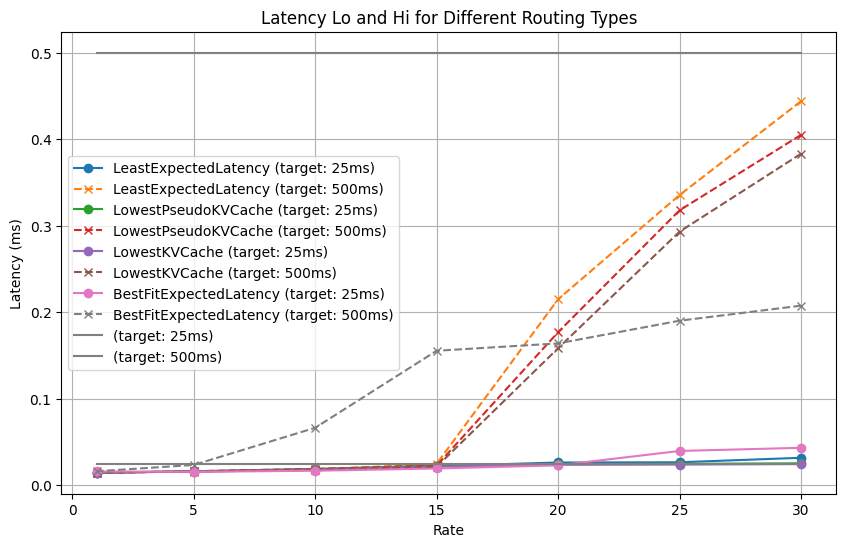

In [ ]:
plt.figure(figsize=(10, 6))

# Plot latency_lo for each routing type
for routing_type in all_routing_types:
    #if routing_type == 'random':
     #   continue
    routing_type_name = "LowestPseudoKVCache"
    if routing_type == 'smart':
        routing_type_name = "BestFitExpectedLatency"
    elif routing_type == 'least':
        routing_type_name = "LowestKVCache"
    elif routing_type == 'leastlatency':
        routing_type_name = "LeastExpectedLatency"

    results[routing_type]['latency_lo']

    plt.plot(rates_lo, results[routing_type]['latency_lo'], marker='o', linestyle = '-', label=f'{routing_type_name} (target: 25ms)')
    plt.plot(rates_hi, results[routing_type]['latency_hi'], marker='x', linestyle ='--', label=f'{routing_type_name} (target: 500ms)')




# Adding labels and title
plt.plot(rates_lo, [0.025]*len(rates_lo),linestyle = '-', label=f'(target: 25ms)', color = 'grey')
plt.plot(rates_hi, [0.5]*len(rates_hi),linestyle = '-', label=f'(target: 500ms)',color = 'grey')
plt.xlabel('Rate')
plt.ylabel('Latency (ms)')
plt.title('Latency Lo and Hi for Different Routing Types')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

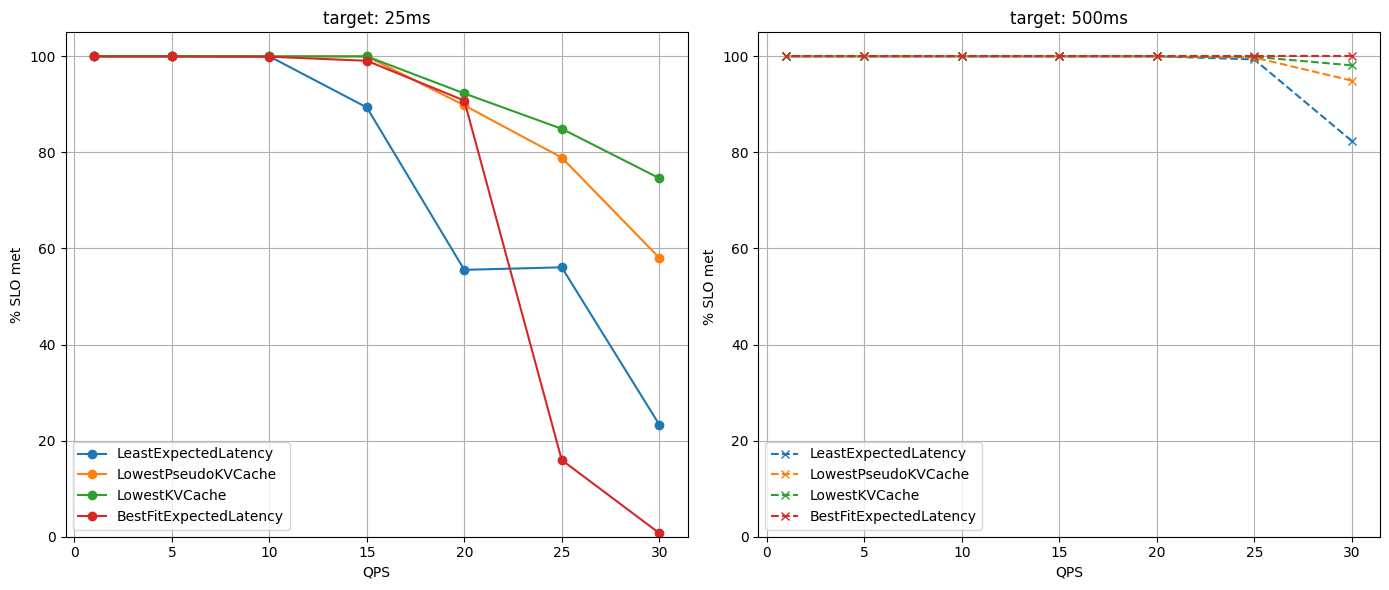

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot latency_lo for each routing type on the left subplot
for routing_type in all_routing_types:

    routing_type_name = "LowestPseudoKVCache"
    if routing_type == 'smart':
        routing_type_name = "BestFitExpectedLatency"
    elif routing_type == 'least':
        routing_type_name = "LowestKVCache"
    elif routing_type == 'leastlatency':
        routing_type_name = "LeastExpectedLatency"

    axes[0].plot(rates_lo, results[routing_type]['pct_below_latency_target_lo'], marker='o', linestyle='-', label=f'{routing_type_name}')

# Adding labels, title, and legend for latency_lo
axes[0].set_xlabel('QPS')
axes[0].set_ylabel('% SLO met')
axes[0].set_title('target: 25ms')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0, 105)

# Plot latency_hi for each routing type on the right subplot
for routing_type in all_routing_types:
    routing_type_name = "LowestPseudoKVCache"
    if routing_type == 'smart':
        routing_type_name = "BestFitExpectedLatency"
    elif routing_type == 'least':
        routing_type_name = "LowestKVCache"
    elif routing_type == 'leastlatency':
        routing_type_name = "LeastExpectedLatency"
    linestyle = '-' if routing_type == 'smart' else '--'
    axes[1].plot(rates_hi, results[routing_type]['pct_below_latency_target_hi'], marker='x', linestyle='--', label=f'{routing_type_name}')

# Adding labels, title, and legend for latency_hi
axes[1].set_xlabel('QPS')
axes[1].set_ylabel('% SLO met ')
axes[1].set_ylim(0, 105)
axes[1].set_title('target: 500ms')
axes[1].legend()
axes[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


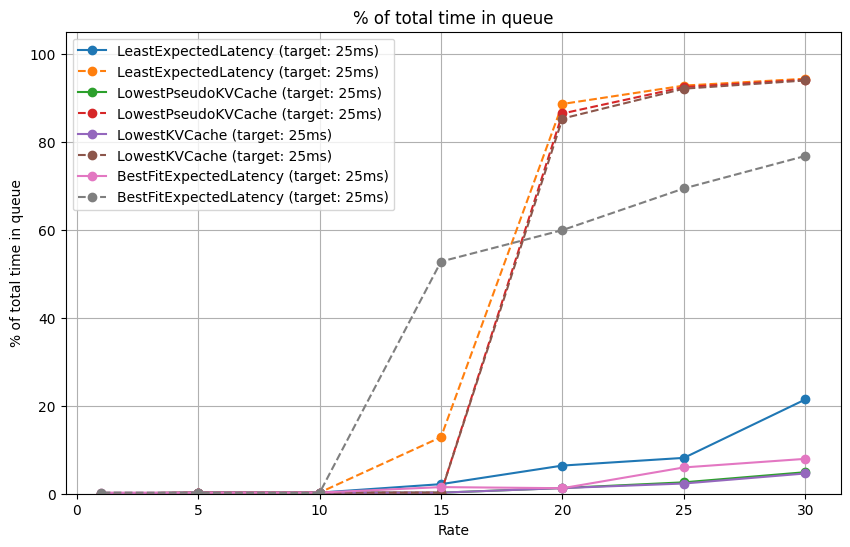

In [ ]:
plt.figure(figsize=(10, 6))

# Plot latency_lo for each routing type
for routing_type in all_routing_types:
    #if routing_type == 'random':
     #   continue
    routing_type_name = "LowestPseudoKVCache"
    if routing_type == 'smart':
        routing_type_name = "BestFitExpectedLatency"
    elif routing_type == 'least':
        routing_type_name = "LowestKVCache"
    elif routing_type == 'leastlatency':
        routing_type_name = "LeastExpectedLatency"

    results[routing_type]['latency_lo']



    plt.plot(rates_lo, [results[routing_type]['queue_time_lo'][i]/results[routing_type]['tol_lat_time_lo'][i] * 100 for i in range(len(results[routing_type]['queue_time_lo']))], marker='o', linestyle = '-', label=f'{routing_type_name} (target: 25ms)')
    plt.plot(rates_lo, [results[routing_type]['queue_time_hi'][i]/results[routing_type]['tol_lat_time_hi'][i] * 100 for i in range(len(results[routing_type]['queue_time_hi']))], marker='o', linestyle = '--', label=f'{routing_type_name} (target: 25ms)')





plt.xlabel('Rate')
plt.ylabel('% of total time in queue')
plt.title('% of total time in queue')
plt.ylim(0, 105)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

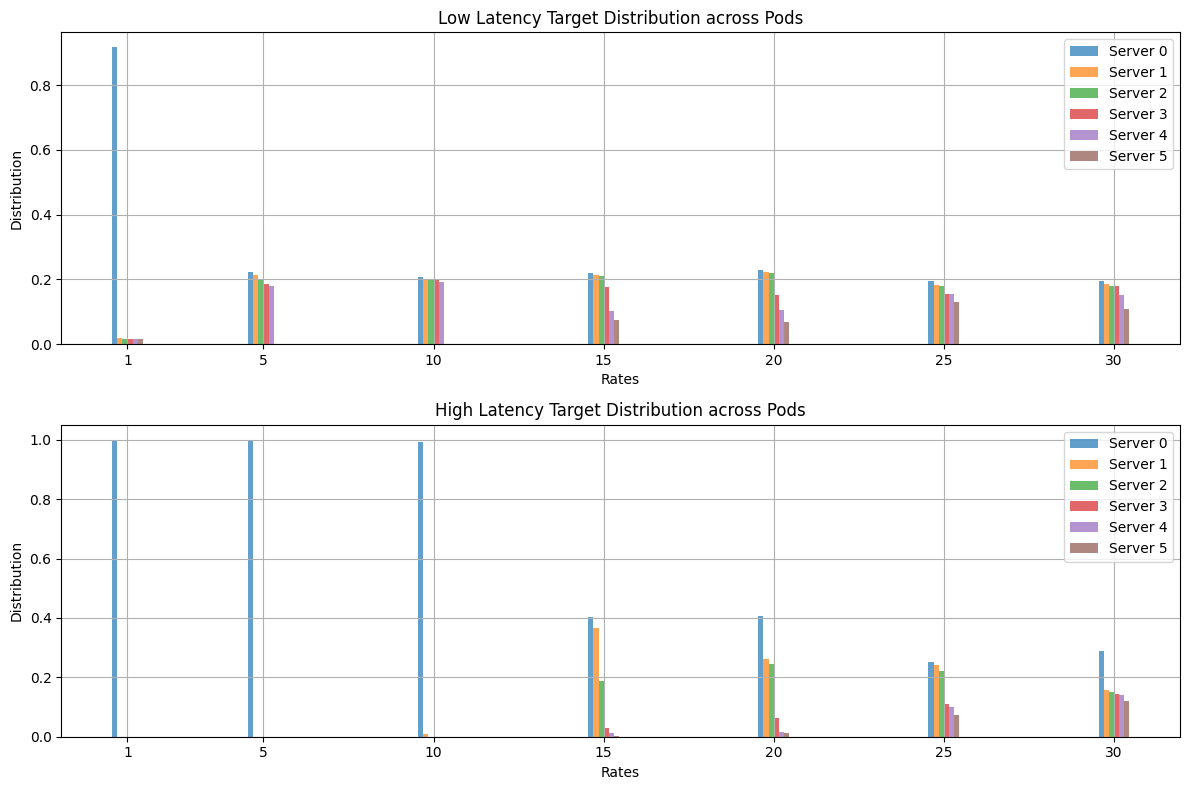

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data setup for the rates and results
pods = [0, 1, 2, 3, 4, 5]
num_pods = len(pods)
bar_width = 0.15  # Width of each bar in the group

# Normalize target_pods distributions
target_pods_lo_std = [np.array(sorted(list(x.values()), reverse=True)) / np.sum(list(x.values())) for x in results['smart']['target_pods_lo']]
target_pods_hi_std = [np.array(sorted(list(x.values()), reverse=True)) / np.sum(list(x.values())) for x in results['smart']['target_pods_hi']]

# Plotting histograms for each rate
plt.figure(figsize=(12, 8))

# Loop over both low and high standard deviations
for i, (rates, target_pods_std, title) in enumerate(zip(
        [rates_lo, rates_hi],
        [target_pods_lo_std, target_pods_hi_std],
        ['Low Latency Target', 'High Latency Target'])):

    plt.subplot(2, 1, i + 1)

    # Adjust the x positions to make bars side by side
    for pod_index, pod in enumerate(pods):
        # Shift the bar positions for each pod
        bar_positions = np.array(rates) + pod_index * bar_width

        # Get the distribution for each pod
        data = [x[pod] if len(x) > pod else 0 for x in target_pods_std]

        # Plot the bars for this pod
        plt.bar(bar_positions, data, width=bar_width, label=f'Server {pod}', alpha=0.7)

    # Adjust x-axis to account for the shifted bar positions
    plt.xticks(np.array(rates) + (num_pods - 1) * bar_width / 2, rates)

    plt.title(f'{title} Distribution across Pods')
    plt.xlabel('Rates')
    plt.ylabel('Distribution')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


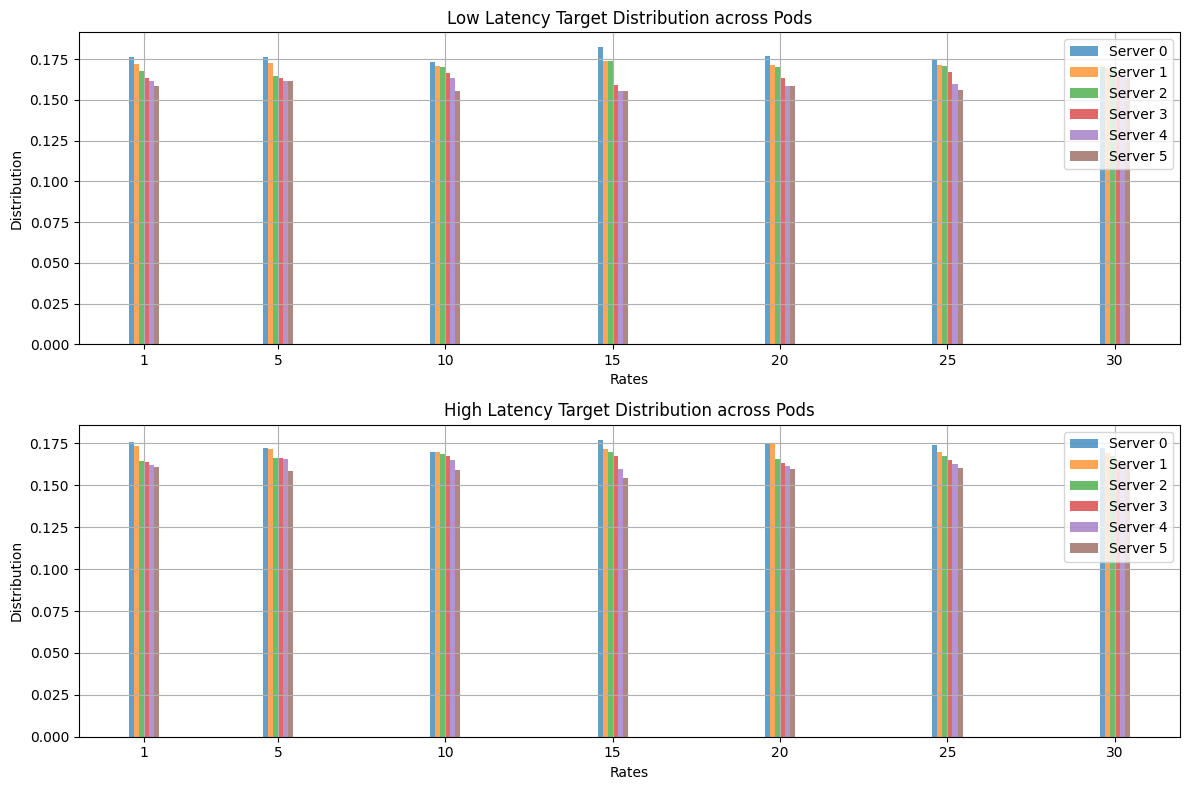

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example data setup for the rates and results
pods = [0, 1, 2, 3, 4, 5]
num_pods = len(pods)
bar_width = 0.15  # Width of each bar in the group

# Normalize target_pods distributions
target_pods_lo_std = [np.array(sorted(list(x.values()), reverse=True)) / np.sum(list(x.values())) for x in results['least']['target_pods_lo']]
target_pods_hi_std = [np.array(sorted(list(x.values()), reverse=True)) / np.sum(list(x.values())) for x in results['least']['target_pods_hi']]

# Plotting histograms for each rate
plt.figure(figsize=(12, 8))

# Loop over both low and high standard deviations
for i, (rates, target_pods_std, title) in enumerate(zip(
        [rates_lo, rates_hi],
        [target_pods_lo_std, target_pods_hi_std],
        ['Low Latency Target', 'High Latency Target'])):

    plt.subplot(2, 1, i + 1)

    # Adjust the x positions to make bars side by side
    for pod_index, pod in enumerate(pods):
        # Shift the bar positions for each pod
        bar_positions = np.array(rates) + pod_index * bar_width

        # Get the distribution for each pod
        data = [x[pod] if len(x) > pod else 0 for x in target_pods_std]

        # Plot the bars for this pod
        plt.bar(bar_positions, data, width=bar_width, label=f'Server {pod}', alpha=0.7)

    # Adjust x-axis to account for the shifted bar positions
    plt.xticks(np.array(rates) + (num_pods - 1) * bar_width / 2, rates)

    plt.title(f'{title} Distribution across Pods')
    plt.xlabel('Rates')
    plt.ylabel('Distribution')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
